In [1]:
import os
import shutil
from collections import defaultdict

import pandas as pd
import polars as pl
import pydicom

import kaggle_evaluation.rsna_inference_server

The evaluation API requires that you set up a server which will respond to inference requests. We have already defined the server; you just need write the predict function. When we evaluate your submission on the hidden test set the client defined in `rsna_gateway` will run in a different container with direct access to the hidden test set and hand off the data series by series.

Your code will always have access to the published copies of the files.

In [2]:
import os

base_path = "/kaggle/input/rsna-intracranial-aneurysm-detection"
for root, dirs, files in os.walk(base_path):
    print(root, len(files))
    break


/kaggle/input/rsna-intracranial-aneurysm-detection 2


Example Series: 1.2.826.0.1.3680043.8.498.96155132589464464482407972219172224468
Number of DICOM slices: 120


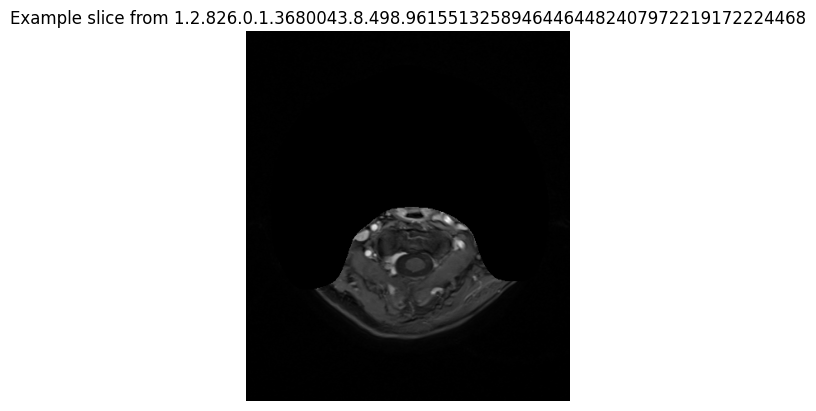

In [3]:
import os, pydicom
import matplotlib.pyplot as plt

base_path = "/kaggle/input/rsna-intracranial-aneurysm-detection"

# pick one example
series_id = os.listdir(f"{base_path}/series")[0]
series_folder = f"{base_path}/series/{series_id}"

print("Example Series:", series_id)
print("Number of DICOM slices:", len(os.listdir(series_folder)))

# read one slice
example_dcm = os.path.join(series_folder, os.listdir(series_folder)[0])
dcm = pydicom.dcmread(example_dcm)

plt.imshow(dcm.pixel_array, cmap='gray')
plt.title(f"Example slice from {series_id}")
plt.axis("off")
plt.show()


**STEP 1- Preprocessing**

Convert DICOM slices → 3D volumes:

In [4]:
import pydicom, numpy as np, os

def load_series(series_path):
    files = sorted(os.listdir(series_path))
    volume = [pydicom.dcmread(os.path.join(series_path, f)).pixel_array for f in files]
    volume = np.stack(volume)
    return volume


Then window + normalize intensity (CT windowing helps isolate vessels):

In [5]:
def normalize(volume, min_hu=-100, max_hu=400):
    volume = np.clip(volume, min_hu, max_hu)
    volume = (volume - min_hu) / (max_hu - min_hu)
    return volume


In [9]:
import torch, monai

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("MONAI version:", monai.__version__)

# quick GPU memory check
!nvidia-smi


<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-10-14 03:03:15.712958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760410995.929654      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760410995.992629      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Torch version: 2.6.0+cu124
CUDA available: True
MONAI version: 1.6.dev2541
Tue Oct 14 03:03:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                      

**Step 2 — Prepare Segmentation Masks**

Use segmentations/ folder — these are NIfTI (.nii.gz) files matching some SeriesInstanceUIDs

In [10]:
import os

base_dir = "/kaggle/input/rsna-intracranial-aneurysm-detection"
series_dir = os.path.join(base_dir, "series")
seg_dir = os.path.join(base_dir, "segmentations")

series_folders = sorted(os.listdir(series_dir))
seg_files = os.listdir(seg_dir)

# Normalize segmentation file names (strip extensions and suffixes)
normalized_seg_ids = {
    f.replace("_cowseg", "").replace(".nii", ""): f for f in seg_files
}

data_dicts = []
for folder in series_folders:
    uid = folder.strip()
    if uid in normalized_seg_ids:
        seg_file = normalized_seg_ids[uid]
        seg_path = os.path.join(seg_dir, seg_file)
        img_path = os.path.join(series_dir, uid)
        data_dicts.append({"image": img_path, "label": seg_path})

print(f"✅ Matched {len(data_dicts)} image-mask pairs out of {len(series_folders)} series.")


✅ Matched 177 image-mask pairs out of 4348 series.


In [29]:
for i in range(5):
    print(data_dicts[i])


{'image': '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381', 'label': '/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381_cowseg.nii'}
{'image': '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10076056930521523789588901704956188485', 'label': '/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/1.2.826.0.1.3680043.8.498.10076056930521523789588901704956188485.nii'}
{'image': '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10188636688783982623025997809119805350', 'label': '/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/1.2.826.0.1.3680043.8.498.10188636688783982623025997809119805350.nii'}
{'image': '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10410600166004340343973545138447283460', 'label': '/

**Step 3 — Resize to Manageable Size**

Most RSNA scans are large (512×512×>100 slices).
Downsample to something like (128, 128, 64) for training speed:

In [7]:
import torch
import torch.nn.functional as F

def resize_volume(vol, target=(128, 128, 64)):
    vol = torch.tensor(vol).unsqueeze(0).unsqueeze(0)
    resized = F.interpolate(vol, size=target, mode='trilinear', align_corners=False)
    return resized.squeeze().numpy()


**Step 4 — Train a 3D UNet Segmentation Model**

A 3D U-Net is perfect here — it captures spatial context in all three axes.

In [8]:
!pip install -q --upgrade pip
!pip install -q "monai-weekly[nibabel,pydicom]" -f https://download.pytorch.org/whl/torch_stable.html


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.4 MB/s eta 0:00:0000:0100:01


In [23]:
import os
import numpy as np
import nibabel as nib
import pydicom
import torch
import matplotlib.pyplot as plt
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd, ScaleIntensityd,
    RandFlipd, RandRotate90d, EnsureTyped, Compose
)

from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism


In [26]:
import os

series_dir = "/kaggle/input/rsna-intracranial-aneurysm-detection/series"
seg_dir = "/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations"

print("📂 Series folder examples:")
print(os.listdir(series_dir)[:5])

print("\n📂 Segmentations folder examples:")
print(os.listdir(seg_dir)[:5])


📂 Series folder examples:
['1.2.826.0.1.3680043.8.498.96155132589464464482407972219172224468', '1.2.826.0.1.3680043.8.498.41711215539877472420239257090976077218', '1.2.826.0.1.3680043.8.498.86837346700151751310565181236786678013', '1.2.826.0.1.3680043.8.498.93188368164507061784389222177130312553', '1.2.826.0.1.3680043.8.498.10775557483309974755100932459198402019']

📂 Segmentations folder examples:
['1.2.826.0.1.3680043.8.498.62169558538817009391695314359016512306.nii', '1.2.826.0.1.3680043.8.498.15111820005882064793593034423469604305_cowseg.nii', '1.2.826.0.1.3680043.8.498.17415277997649872560329721717694101082_cowseg.nii', '1.2.826.0.1.3680043.8.498.56479623144539472445940519727300319231_cowseg.nii', '1.2.826.0.1.3680043.8.498.79221197357738210862579456170058377494.nii']


✅ Matched 177 image-mask pairs.
Using device: cuda


Epoch 1:  52%|█████▏    | 89/172 [05:41<03:07,  2.26s/it] /usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
Epoch 1:  61%|██████    | 105/172 [07:00<05:27,  4.89s/it]/usr/local/lib/python3.11/dist-packages/monai/data/image_reader.py:590: UserWarning: the list contains slices that have different spacings [0.450156, 0.450156] and [0.430000, 0.430000].
  warnings.warn(f"the list contains slices that have different spacings {spacing} and {slc_spacing}.")
Epoch 1: 100%|██████████| 172/172 [12:04<00:00,  4.21s/it]


Epoch 1 | TrainLoss -80.8148 | ValDice 0.0094
✅ Saved new best model.


Epoch 2:  22%|██▏       | 38/172 [02:41<03:17,  1.48s/it] /usr/local/lib/python3.11/dist-packages/monai/data/image_reader.py:590: UserWarning: the list contains slices that have different spacings [0.450156, 0.450156] and [0.430000, 0.430000].
  warnings.warn(f"the list contains slices that have different spacings {spacing} and {slc_spacing}.")
Epoch 2:  86%|████████▌ | 148/172 [10:12<03:30,  8.75s/it]/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
Epoch 2: 100%|██████████| 172/172 [12:06<00:00,  4.22s/it]


Epoch 2 | TrainLoss -119.2131 | ValDice 0.0336
✅ Saved new best model.


Epoch 3:  10%|█         | 18/172 [01:29<09:40,  3.77s/it]/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
Epoch 3:  31%|███▏      | 54/172 [03:44<05:21,  2.72s/it]/usr/local/lib/python3.11/dist-packages/monai/data/image_reader.py:590: UserWarning: the list contains slices that have different spacings [0.450156, 0.450156] and [0.430000, 0.430000].
  warnings.warn(f"the list contains slices that have different spacings {spacing} and {slc_spacing}.")
Epoch 3: 100%|██████████| 172/172 [11:14<00:00,  3.92s/it]


Epoch 3 | TrainLoss -145.6338 | ValDice 0.0442
✅ Saved new best model.


Epoch 4:  25%|██▌       | 43/172 [02:29<08:11,  3.81s/it]/usr/local/lib/python3.11/dist-packages/monai/data/image_reader.py:590: UserWarning: the list contains slices that have different spacings [0.450156, 0.450156] and [0.430000, 0.430000].
  warnings.warn(f"the list contains slices that have different spacings {spacing} and {slc_spacing}.")
Epoch 4:  66%|██████▌   | 113/172 [07:17<03:07,  3.18s/it]/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
Epoch 4: 100%|██████████| 172/172 [11:20<00:00,  3.96s/it]


Epoch 4 | TrainLoss -168.1226 | ValDice 0.0543
✅ Saved new best model.


Epoch 5:  32%|███▏      | 55/172 [02:51<06:11,  3.18s/it]/usr/local/lib/python3.11/dist-packages/monai/data/image_reader.py:590: UserWarning: the list contains slices that have different spacings [0.450156, 0.450156] and [0.430000, 0.430000].
  warnings.warn(f"the list contains slices that have different spacings {spacing} and {slc_spacing}.")
Epoch 5:  95%|█████████▍| 163/172 [10:32<00:07,  1.23it/s]/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
Epoch 5: 100%|██████████| 172/172 [11:33<00:00,  4.03s/it]


Epoch 5 | TrainLoss -189.9557 | ValDice 0.0575
✅ Saved new best model.


Epoch 6:  38%|███▊      | 65/172 [04:57<10:49,  6.07s/it]/usr/local/lib/python3.11/dist-packages/monai/data/image_reader.py:590: UserWarning: the list contains slices that have different spacings [0.450156, 0.450156] and [0.430000, 0.430000].
  warnings.warn(f"the list contains slices that have different spacings {spacing} and {slc_spacing}.")
Epoch 6:  73%|███████▎  | 125/172 [09:03<01:36,  2.05s/it]/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
Epoch 6: 100%|██████████| 172/172 [12:31<00:00,  4.37s/it]


Epoch 6 | TrainLoss -213.3135 | ValDice 0.0587
✅ Saved new best model.


Epoch 7:  39%|███▉      | 67/172 [05:11<02:53,  1.65s/it]/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
Epoch 7:  84%|████████▍ | 145/172 [10:46<00:49,  1.85s/it]/usr/local/lib/python3.11/dist-packages/monai/data/image_reader.py:590: UserWarning: the list contains slices that have different spacings [0.450156, 0.450156] and [0.430000, 0.430000].
  warnings.warn(f"the list contains slices that have different spacings {spacing} and {slc_spacing}.")
Epoch 7: 100%|██████████| 172/172 [12:27<00:00,  4.35s/it]


Epoch 7 | TrainLoss -235.1335 | ValDice 0.0593
✅ Saved new best model.


Epoch 8:  20%|█▉        | 34/172 [02:51<08:45,  3.80s/it] /usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
Epoch 8:  41%|████      | 70/172 [05:34<10:24,  6.12s/it]/usr/local/lib/python3.11/dist-packages/monai/data/image_reader.py:590: UserWarning: the list contains slices that have different spacings [0.450156, 0.450156] and [0.430000, 0.430000].
  warnings.warn(f"the list contains slices that have different spacings {spacing} and {slc_spacing}.")
Epoch 8: 100%|██████████| 172/172 [12:22<00:00,  4.32s/it]


Epoch 8 | TrainLoss -255.8707 | ValDice 0.0591


Epoch 9:  63%|██████▎   | 109/172 [07:30<04:50,  4.61s/it]/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
Epoch 9:  87%|████████▋ | 150/172 [11:11<02:11,  5.97s/it]/usr/local/lib/python3.11/dist-packages/monai/data/image_reader.py:590: UserWarning: the list contains slices that have different spacings [0.450156, 0.450156] and [0.430000, 0.430000].
  warnings.warn(f"the list contains slices that have different spacings {spacing} and {slc_spacing}.")
Epoch 9: 100%|██████████| 172/172 [12:31<00:00,  4.37s/it]


Epoch 9 | TrainLoss -278.2784 | ValDice 0.0566


Epoch 10:  33%|███▎      | 57/172 [04:00<06:23,  3.33s/it]/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
Epoch 10:  40%|███▉      | 68/172 [04:40<03:41,  2.13s/it]/usr/local/lib/python3.11/dist-packages/monai/data/image_reader.py:590: UserWarning: the list contains slices that have different spacings [0.450156, 0.450156] and [0.430000, 0.430000].
  warnings.warn(f"the list contains slices that have different spacings {spacing} and {slc_spacing}.")
Epoch 10: 100%|██████████| 172/172 [12:14<00:00,  4.27s/it]


Epoch 10 | TrainLoss -298.3043 | ValDice 0.0596
✅ Saved new best model.


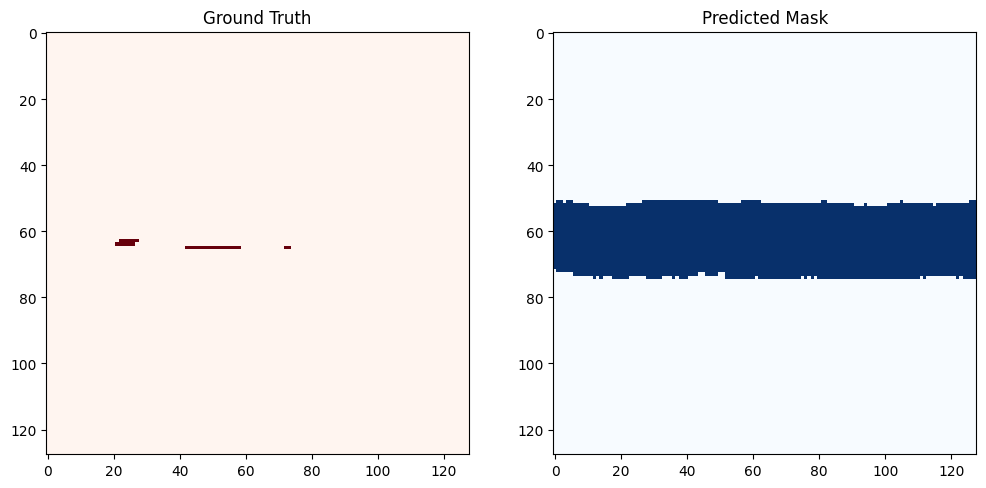

In [12]:
# ======================================
# ✅ 1. INSTALL + IMPORTS
# ======================================
!pip install -q monai nibabel pydicom tqdm

import os, numpy as np, torch, nibabel as nib, pydicom, matplotlib.pyplot as plt
from tqdm import tqdm
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Orientationd, ScaleIntensityd,
    RandFlipd, RandRotate90d, RandAdjustContrastd,
    EnsureTyped, Compose, MapTransform, ResizeWithPadOrCropd
)
from monai.data import Dataset, DataLoader
from monai.data.utils import pad_list_data_collate
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism

# ======================================
# ✅ 2. CUSTOM FIX (replaces EnsureDivisibleD)
# ======================================
class EnsureMultipleOf16D(MapTransform):
    """
    Ensures each spatial dimension is divisible by 16
    by symmetrically padding as needed.
    """
    def __init__(self, keys, mode="constant"):
        super().__init__(keys)
        self.mode = mode

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            img = d[key]
            shape = np.array(img.shape[-3:])
            pad = (16 - shape % 16) % 16
            pad_before = pad // 2
            pad_after = pad - pad_before
            pad_width = [
                (pad_before[0], pad_after[0]),
                (pad_before[1], pad_after[1]),
                (pad_before[2], pad_after[2])
            ]
            if np.any(pad > 0):
                img = np.pad(img, [(0,0)]*(img.ndim-3) + pad_width, mode=self.mode)
            d[key] = img
        return d


# ======================================
# ✅ 3. PATHS + MATCHING
# ======================================
base_dir = "/kaggle/input/rsna-intracranial-aneurysm-detection"
series_dir, seg_dir = os.path.join(base_dir, "series"), os.path.join(base_dir, "segmentations")

series_folders = sorted(os.listdir(series_dir))
seg_files = os.listdir(seg_dir)
normalized_seg_ids = {f.replace("_cowseg","").replace(".nii",""): f for f in seg_files}

data_dicts = []
for folder in series_folders:
    uid = folder.strip()
    if uid in normalized_seg_ids:
        seg_path = os.path.join(seg_dir, normalized_seg_ids[uid])
        img_path = os.path.join(series_dir, uid)
        data_dicts.append({"image": img_path, "label": seg_path})
print(f"✅ Matched {len(data_dicts)} image-mask pairs.")

# ======================================
# ✅ 4. TRANSFORMS (with consistent patch size)
# ======================================
train_transforms = Compose([
    LoadImaged(keys=["image","label"]),
    EnsureChannelFirstd(keys=["image","label"]),
    Orientationd(keys=["image","label"], axcodes="RAS"),
    ScaleIntensityd(keys=["image"]),
    ResizeWithPadOrCropd(keys=["image","label"], spatial_size=(128,128,128)),  # uniform size
    EnsureMultipleOf16D(keys=["image","label"]),  # shape safety
    RandFlipd(keys=["image","label"], prob=0.5, spatial_axis=[0,1,2]),
    RandRotate90d(keys=["image","label"], prob=0.5, max_k=3),
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.7,1.5)),
    EnsureTyped(keys=["image","label"]),
])

val_transforms = Compose([
    LoadImaged(keys=["image","label"]),
    EnsureChannelFirstd(keys=["image","label"]),
    Orientationd(keys=["image","label"], axcodes="RAS"),
    ScaleIntensityd(keys=["image"]),
    ResizeWithPadOrCropd(keys=["image","label"], spatial_size=(128,128,128)),
    EnsureMultipleOf16D(keys=["image","label"]),
    EnsureTyped(keys=["image","label"]),
])

train_files, val_files = data_dicts[:-5], data_dicts[-5:]
train_ds, val_ds = Dataset(train_files, train_transforms), Dataset(val_files, val_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2, collate_fn=pad_list_data_collate)
val_loader   = DataLoader(val_ds, batch_size=1, num_workers=2, collate_fn=pad_list_data_collate)

# ======================================
# ✅ 5. MODEL + SETUP
# ======================================
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet(
    spatial_dims=3, in_channels=1, out_channels=1,
    channels=(16,32,64,128,256),
    strides=(2,2,2,2),
    num_res_units=2
).to(device)

loss_function = DiceCELoss(sigmoid=True)
optimizer     = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric   = DiceMetric(include_background=False, reduction="mean")

best_dice, best_model = 0, "/kaggle/working/best_patch_unet.pth"

# ======================================
# ✅ 6. TRAINING LOOP
# ======================================
for epoch in range(10):   # 🔁 increase to 50+ for better Dice
    model.train(); epoch_loss = 0
    for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward(); optimizer.step()
        epoch_loss += loss.item()

    # ---------- Validation ----------
    model.eval(); dice_vals = []
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
            val_outputs = sliding_window_inference(val_inputs, (128,128,128), 2, model, overlap=0.25)
            dice_vals.append(dice_metric(y_pred=torch.sigmoid(val_outputs), y=val_labels).item())
    avg_dice = np.mean(dice_vals)
    print(f"Epoch {epoch+1} | TrainLoss {epoch_loss/len(train_loader):.4f} | ValDice {avg_dice:.4f}")

    if avg_dice > best_dice:
        best_dice = avg_dice
        torch.save(model.state_dict(), best_model)
        print("✅ Saved new best model.")

# ======================================
# ✅ 7. VISUALIZATION
# ======================================
model.load_state_dict(torch.load(best_model))
model.eval()

sample = val_ds[0]
img = sample["image"].unsqueeze(0).to(device)
lbl = sample["label"].squeeze().cpu().numpy()

with torch.no_grad():
    pred = torch.sigmoid(sliding_window_inference(img,(128,128,128),2,model)).squeeze().cpu().numpy()

mid = lbl.shape[0]//2
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(lbl[mid,:,:], cmap="Reds"); plt.title("Ground Truth")
plt.subplot(1,2,2); plt.imshow(pred[mid,:,:]>0.5, cmap="Blues"); plt.title("Predicted Mask")
plt.show()
